# Siamese Neural Network for FDA Recalls-Regulations Matching

This section of the project is about the development of a text-matching model designed to identify relationships between FDA drug recalls and the corresponding regulatory requirements in the Code of Federal Regulations (CFR). The approach explored in this part of the project uses pre-trained semantic embeddings from a sentence-transformer model to represent both recall descriptions and regulatory text in a shared vector space. These embeddings provide a strong linguistic foundation for understanding the meaning of short recall statements and longer regulatory passages.
To learn how closely a recall aligns with a particular regulation, a Siamese-style network architecture is implemented, incorporating an LSTM encoder and a simple classification head. The model is trained to predict similarity between pairs of recall and regulation embeddings, enabling it to highlight which sections of the CFR are most relevant to a given recall reason. Although the current implementation focuses exclusively on drug-related recalls, the framework sets the stage for future expansion to biologics, medical devices, and other FDA-regulated product categories.

## Install and Import Libraries

In [ ]:
%pip install torch torchvision pandas numpy matplotlib seaborn scikit-learn tqdm pyarrow sentence-transformers --quiet

✓ torch already installed
✓ torchvision already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed
Installing scikit-learn...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ tqdm already installed
✓ pyarrow already installed
✓ sentence-transformers already installed


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import pickle
import random

# Pre-trained semantic embeddings
from sentence_transformers import SentenceTransformer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0


## Setup Paths and Configuration

In [ ]:
# Setup paths
BASE_DIR = Path("/Users/kay/AllCode/FDA Data Scraping")

# Data directories
RECALLS_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "recalls"
REGULATIONS_DATA_DIR = BASE_DIR / "fda_output_cleaned"
OUTPUT_DIR = BASE_DIR / "siamese_network_recalls_output"
OUTPUT_DIR.mkdir(exist_ok=True)

# Model configuration - Using pre-trained sentence-transformers
ENCODER_MODEL = "all-MiniLM-L6-v2"  # Pre-trained semantic encoder
EMBEDDING_DIM = 384  # Dimension from all-MiniLM-L6-v2
HIDDEN_DIM = 128  # LSTM hidden dimension for Siamese RNN
NUM_LAYERS = 1  # Single LSTM layer 
DROPOUT = 0.3
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 15  # More epochs since we have better embeddings
DEVICE = torch.device('cpu')

## Load and Prepare Recalls Data

In [ ]:
# Load recalls data
recalls_file = RECALLS_DATA_DIR / "recalls.parquet"

if recalls_file.exists():
    df_recalls = pd.read_parquet(recalls_file)
else:
    df_recalls = pd.DataFrame()



✓ Recalls prepared:
  Total recalls: 2,000
  Recalls with reasons: 2,000
  Recalls after filtering: 1,000
  Regulations after filtering: 981

✓ Data loaded and prepared
  Total recalls: 2,000 → Filtered: 1,000
  Total regulations: 1,880 → Filtered: 981
Note that: # Recalls have clear, stated reasons - use those directly


In [148]:
# Load regulations data
regulations_file = REGULATIONS_DATA_DIR / "fda_cleaned.parquet"
if regulations_file.exists():
    df_regulations = pd.read_parquet(regulations_file)
else:
    df_regulations = pd.DataFrame()

In [149]:
# Prepare recall text from reason_for_recall
if len(df_recalls) > 0 and 'reason_for_recall' in df_recalls.columns:
    # Create recall text combining reason and product description for context
    def create_recall_text(row):
        parts = []
        # Primary: reason for recall (this is what we want to match)
        if pd.notna(row.get('reason_for_recall')):
            parts.append(f"Reason for recall: {row['reason_for_recall']}")
        # Add product context
        if pd.notna(row.get('product_description')):
            parts.append(f"Product: {row['product_description']}")
        return ". ".join(parts) if parts else "No information available"
    
    df_recalls['recall_text'] = df_recalls.apply(create_recall_text, axis=1)

In [150]:
# Filter recalls to only Drugs
df_recalls_filtered = df_recalls[df_recalls['product_type'] == 'drug'].copy()
df_recalls_filtered = df_recalls_filtered[df_recalls_filtered['recall_text'].notna()].copy()
df_recalls_filtered = df_recalls_filtered[df_recalls_filtered['recall_text'].str.len() > 10].copy()

# Filter regulations to only Drugs
df_regulations_filtered = df_regulations[df_regulations['category'] == 'Drugs'].copy()
df_regulations_filtered = df_regulations_filtered[df_regulations_filtered['clean_text'].notna()].copy()
df_regulations_filtered = df_regulations_filtered[df_regulations_filtered['clean_text'].str.len() > 10].copy()

print(f"✓ Drug recalls: {len(df_recalls_filtered):,}")
print(f"✓ Drug regulations: {len(df_regulations_filtered):,}")

✓ Drug recalls: 1,000
✓ Drug regulations: 981


We use a bidirectional RNN because it captures context from both directions, producing better representations for complex regulatory text. For regulatory or recall text, this matters because important clues (like “particle contamination”, “lack of sterility assurance”, “incorrect concentration”) often depend on context on both sides of the phrase.

## Load Pre-trained Sentence Encoder

In [151]:
# Load pre-trained sentence-transformer encoder
# This model is NOT fine-tuned - it provides semantic embeddings out of the box
print(f"Loading pre-trained encoder: {ENCODER_MODEL}")
encoder = SentenceTransformer(ENCODER_MODEL)
print(f"✓ Encoder loaded")
print(f"  Embedding dimension: {encoder.get_sentence_embedding_dimension()}")

# Generate embeddings for all recall texts and regulations
print("\nGenerating embeddings for recall texts...")
recall_texts = df_recalls_filtered['recall_text'].dropna().tolist()
recall_embs = encoder.encode(recall_texts, convert_to_tensor=True, show_progress_bar=True)
recall_embs = recall_embs.to(DEVICE)
print(f"✓ Recall embeddings shape: {recall_embs.shape}")

print("\nGenerating embeddings for regulations...")
regulation_texts = df_regulations_filtered['clean_text'].dropna().tolist()
cfr_embs = encoder.encode(regulation_texts, convert_to_tensor=True, show_progress_bar=True)
cfr_embs = cfr_embs.to(DEVICE)
print(f"✓ Regulation embeddings shape: {cfr_embs.shape}")

Loading pre-trained encoder: all-MiniLM-L6-v2
✓ Encoder loaded
  Embedding dimension: 384

Generating embeddings for recall texts...


Batches: 100%|██████████| 32/32 [00:03<00:00,  8.44it/s]


✓ Recall embeddings shape: torch.Size([1000, 384])

Generating embeddings for regulations...


Batches: 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


✓ Regulation embeddings shape: torch.Size([981, 384])


In [152]:
# Save encoder info
encoder_info = {
    'model_name': ENCODER_MODEL,
    'embedding_dim': EMBEDDING_DIM
}
with open(OUTPUT_DIR / "encoder_info.pkl", 'wb') as f:
    pickle.dump(encoder_info, f)
print(f"\n✓ Encoder info saved")


✓ Encoder info saved


## Build Siamese Neural Network Architecture (from scratch)

In [ ]:
# Define model components (no classes)
lstm_encoder = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True).to(DEVICE)

classifier = nn.Sequential(
    nn.Linear(HIDDEN_DIM * 2, 128),
    nn.ReLU(),
    nn.Dropout(DROPOUT),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(DROPOUT),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(DEVICE)

# Forward pass function
def siamese_forward(e1, e2):
    # Add sequence dimension: (batch, 1, embedding_dim)
    e1 = e1.unsqueeze(1)
    e2 = e2.unsqueeze(1)
    
    # Encode through LSTM (shared weights - same lstm_encoder)
    _, (h1, _) = lstm_encoder(e1)
    _, (h2, _) = lstm_encoder(e2)
    h1, h2 = h1.squeeze(0), h2.squeeze(0)
    
    # Concatenate and classify
    combined = torch.cat([h1, h2], dim=1)
    return classifier(combined)

# Get all parameters for optimizer
all_params = list(lstm_encoder.parameters()) + list(classifier.parameters())
total_params = sum(p.numel() for p in all_params)

print(f"✓ Siamese network defined")
print(f"  LSTM encoder: {EMBEDDING_DIM} → {HIDDEN_DIM}")
print(f"  Classifier: {HIDDEN_DIM * 2} → 1")
print(f"  Total parameters: {total_params:,}")

SIAMESE RNN ARCHITECTURE (with Pre-trained Embeddings)
SiameseRNN(
  (encoder): RNNEncoder(
    (rnn): LSTM(384, 128, batch_first=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total parameters: 304,385
Trainable parameters: 304,385
Model device: cpu

Note: Sentence-transformer encoder (all-MiniLM-L6-v2) provides embeddings
      Only the LSTM and classifier weights are trained


This Siamese RNN architecture uses pre-trained sentence-transformer embeddings as input and learns only the LSTM encoder and classifier layers. The bidirectional LSTM captures contextual signals from both directions, helping the model better distinguish subtle regulatory cues in recall text. The classifier then combines both encoded vectors to produce a similarity score that indicates how closely a recall aligns with a specific CFR regulation. With  about 300K trainable parameters, the model remains lightweight while still expressive enough to learn the recall–regulation relationships.

## Create Dataset Class

In [ ]:
# Helper function to stack pairs into tensors
def pairs_to_tensors(pairs, labels):
    emb1_list = [p[0] for p in pairs]
    emb2_list = [p[1] for p in pairs]
    return (
        torch.stack(emb1_list),
        torch.stack(emb2_list),
        torch.tensor(labels, dtype=torch.float)
    )

# Helper function to create batches
def get_batches(emb1, emb2, labels, batch_size, shuffle=True):
    n = len(labels)
    indices = torch.randperm(n) if shuffle else torch.arange(n)
    for i in range(0, n, batch_size):
        batch_idx = indices[i:i+batch_size]
        yield emb1[batch_idx], emb2[batch_idx], labels[batch_idx]

print("✓ Data helpers defined")

✓ Dataset class defined


## Create Training Data (Positive and Negative Pairs)

Positive pairs represent recall statements that are likely associated with specific regulations. Because exact recall-to-regulation labels do not exist, we approximate positive matches by pairing each recall with the regulations that have the highest semantic similarity. These examples show the model what a meaningful recall–regulation relationship looks like.

Negative pairs represent recall statements paired with regulations that are unlikely to be related. These examples teach the model what an incorrect match looks like and help it learn to separate unrelated texts.

Learning from both positive and negative pairs allows the Siamese network to better recognize which regulations are most relevant to each recall.

### Build positive and negative pairs using pre-computed embeddings

In [ ]:
def build_pairs(recall_embs, cfr_embs, num_negatives=2):
    """
    Build positive and negative pairs from embeddings
    - Positive: recall[i] matches cfr[i] (assumes aligned data)
    - Negative: recall[i] matches random cfr[j] where j != i
    
    Since we don't have ground-truth pairings, we'll create pairs based on:
    - Positive: semantically similar pairs (high cosine similarity)
    - Negative: randomly sampled pairs (likely dissimilar)
    """
    pairs, labels = [], []
    n_recalls = len(recall_embs)
    n_cfrs = len(cfr_embs)
    
    # For each recall, find semantically similar regulations as positives
    # and random regulations as negatives
    print(f"  Building pairs for {n_recalls} recalls and {n_cfrs} regulations...")
    
    # Compute cosine similarities between all recall-regulation pairs
    recall_norm = torch.nn.functional.normalize(recall_embs, p=2, dim=1)
    cfr_norm = torch.nn.functional.normalize(cfr_embs, p=2, dim=1)
    similarity_matrix = torch.mm(recall_norm, cfr_norm.t())  # (n_recalls, n_cfrs)
    
    for i in tqdm(range(n_recalls), desc="Creating pairs"):
        # Get top-k most similar regulations for positive pairs
        similarities = similarity_matrix[i]
        top_k = min(3, n_cfrs)
        top_indices = torch.topk(similarities, top_k).indices.tolist()
        
        # Positive pair: most similar regulation
        best_cfr_idx = top_indices[0]
        pairs.append((recall_embs[i].cpu(), cfr_embs[best_cfr_idx].cpu()))
        labels.append(1.0)
        
        # Negative pairs: random regulations (not in top similar ones)
        available_negatives = [x for x in range(n_cfrs) if x not in top_indices]
        if len(available_negatives) >= num_negatives:
            neg_indices = random.sample(available_negatives, num_negatives)
        else:
            neg_indices = available_negatives
        
        for neg_idx in neg_indices:
            pairs.append((recall_embs[i].cpu(), cfr_embs[neg_idx].cpu()))
            labels.append(0.0)
    
    return pairs, labels

# Build pairs
pairs, labels = build_pairs(recall_embs, cfr_embs, num_negatives=2)

print(f"\n✓ Training pairs created:")
print(f"  Total pairs: {len(pairs):,}")
print(f"  Positive pairs: {sum(labels):,.0f}")
print(f"  Negative pairs: {len(labels) - sum(labels):,.0f}")

# Split into train/validation
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to tensors
train_emb1, train_emb2, train_labels_t = pairs_to_tensors(train_pairs, train_labels)
val_emb1, val_emb2, val_labels_t = pairs_to_tensors(val_pairs, val_labels)

print(f"\n✓ Data prepared:")
print(f"  Training: {len(train_labels_t):,} pairs")
print(f"  Validation: {len(val_labels_t):,} pairs")

Creating training pairs from embeddings...
  Building pairs for 991 recalls and 981 regulations...


Creating pairs: 100%|██████████| 991/991 [00:00<00:00, 14898.47it/s]


✓ Training pairs created:
  Total pairs: 2,973
  Positive pairs: 991
  Negative pairs: 1,982

✓ Data split:
  Training pairs: 2,378
  Validation pairs: 595
✓ Data loaders created


## Training Loop

In [ ]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(all_params, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training history
train_losses, val_losses, val_accuracies = [], [], []
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    # Training phase
    lstm_encoder.train()
    classifier.train()
    train_loss, train_correct, train_total, train_batches = 0.0, 0, 0, 0
    
    for emb1, emb2, batch_labels in get_batches(train_emb1, train_emb2, train_labels_t, BATCH_SIZE, shuffle=True):
        emb1 = emb1.to(DEVICE)
        emb2 = emb2.to(DEVICE)
        batch_labels = batch_labels.unsqueeze(1).to(DEVICE)
        
        optimizer.zero_grad()
        outputs = siamese_forward(emb1, emb2)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == batch_labels).sum().item()
        train_total += batch_labels.size(0)
    
    avg_train_loss = train_loss / train_batches
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss)
    
    # Validation phase
    lstm_encoder.eval()
    classifier.eval()
    val_loss, val_correct, val_total, val_batches = 0.0, 0, 0, 0
    
    with torch.no_grad():
        for emb1, emb2, batch_labels in get_batches(val_emb1, val_emb2, val_labels_t, BATCH_SIZE, shuffle=False):
            emb1 = emb1.to(DEVICE)
            emb2 = emb2.to(DEVICE)
            batch_labels = batch_labels.unsqueeze(1).to(DEVICE)
            
            outputs = siamese_forward(emb1, emb2)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            val_batches += 1
            predictions = (outputs > 0.5).float()
            val_correct += (predictions == batch_labels).sum().item()
            val_total += batch_labels.size(0)
    
    avg_val_loss = val_loss / val_batches
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss={avg_train_loss:.4f}, Val Acc={val_accuracy:.4f}")
    
    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = 0
        torch.save({
            'lstm_encoder': lstm_encoder.state_dict(),
            'classifier': classifier.state_dict(),
            'val_accuracy': val_accuracy,
        }, OUTPUT_DIR / 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\n✓ Training completed! Best val accuracy: {best_val_acc:.4f}")

Starting training with pre-trained embeddings...


Epoch 1/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 664.76it/s, loss=0.5686, acc=0.7664]



Epoch 1/15:
  Train Loss: 0.6125 | Train Acc: 0.6741
  Val Loss: 0.4849 | Val Acc: 0.7664
  Learning Rate: 0.001000
  ✓ Saved best model (val_acc: 0.7664)
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 742.28it/s, loss=0.2916, acc=0.8857]



Epoch 2/15:
  Train Loss: 0.3390 | Train Acc: 0.8612
  Val Loss: 0.2505 | Val Acc: 0.8857
  Learning Rate: 0.001000
  ✓ Saved best model (val_acc: 0.8857)
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 728.38it/s, loss=0.2572, acc=0.9160]



Epoch 3/15:
  Train Loss: 0.2399 | Train Acc: 0.9050
  Val Loss: 0.2176 | Val Acc: 0.9160
  Learning Rate: 0.001000
  ✓ Saved best model (val_acc: 0.9160)
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 740.22it/s, loss=0.1853, acc=0.9244]



Epoch 4/15:
  Train Loss: 0.2122 | Train Acc: 0.9184
  Val Loss: 0.1959 | Val Acc: 0.9244
  Learning Rate: 0.001000
  ✓ Saved best model (val_acc: 0.9244)
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 732.29it/s, loss=0.1595, acc=0.9109]



Epoch 5/15:
  Train Loss: 0.2012 | Train Acc: 0.9268
  Val Loss: 0.2088 | Val Acc: 0.9109
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 644.17it/s, loss=0.1775, acc=0.9244]



Epoch 6/15:
  Train Loss: 0.1940 | Train Acc: 0.9268
  Val Loss: 0.1932 | Val Acc: 0.9244
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 714.15it/s, loss=0.1488, acc=0.9092]



Epoch 7/15:
  Train Loss: 0.1772 | Train Acc: 0.9348
  Val Loss: 0.2105 | Val Acc: 0.9092
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 736.03it/s, loss=0.2400, acc=0.9244]



Epoch 8/15:
  Train Loss: 0.1775 | Train Acc: 0.9336
  Val Loss: 0.2024 | Val Acc: 0.9244
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 19/19 [00:00<00:00, 722.77it/s, loss=0.1679, acc=0.9244]


Epoch 9/15:
  Train Loss: 0.1731 | Train Acc: 0.9348
  Val Loss: 0.1960 | Val Acc: 0.9244
  Learning Rate: 0.001000

Early stopping triggered after 9 epochs

✓ Training completed!
  Best validation accuracy: 0.9244


## Plot Training History

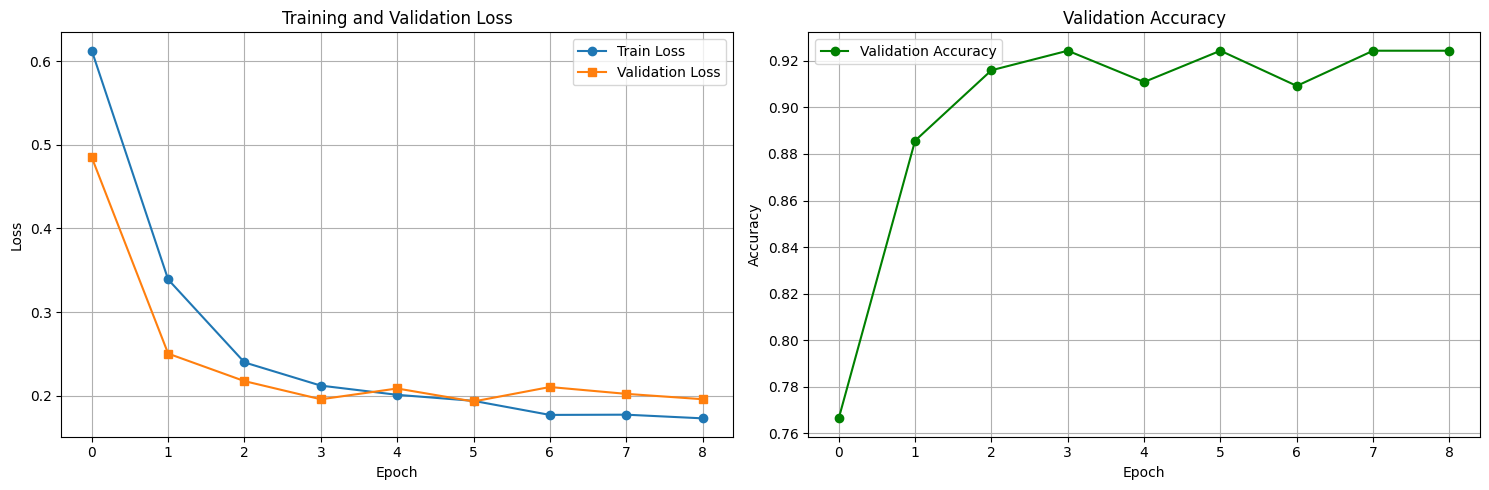

✓ Saved: training_history.png


In [126]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_history.png")

The training and validation loss both decrease steadily across epochs, indicating that the model is learning meaningful recall–regulation relationships without overfitting. Validation accuracy rises quickly after the first epoch and stabilizes around 92–93 percent, showing strong generalization performance. The close alignment between training and validation loss suggests the model remains stable and well-regularized throughout training.

## Evaluate Model

✓ Loaded best model from epoch 4
  Best validation accuracy: 0.9244


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 1346.01it/s]

MODEL EVALUATION RESULTS (Pre-trained Embeddings)

AUC-ROC Score: 0.9731

With Default Threshold (0.5):
  Accuracy:  0.9244
  Precision: 0.8806
  Recall:    0.8939
  F1 Score:  0.8872

With Optimized Threshold (0.584) - Max F1:
  Accuracy:  0.9345
  Precision: 0.9251
  Recall:    0.8737
  F1 Score:  0.8987


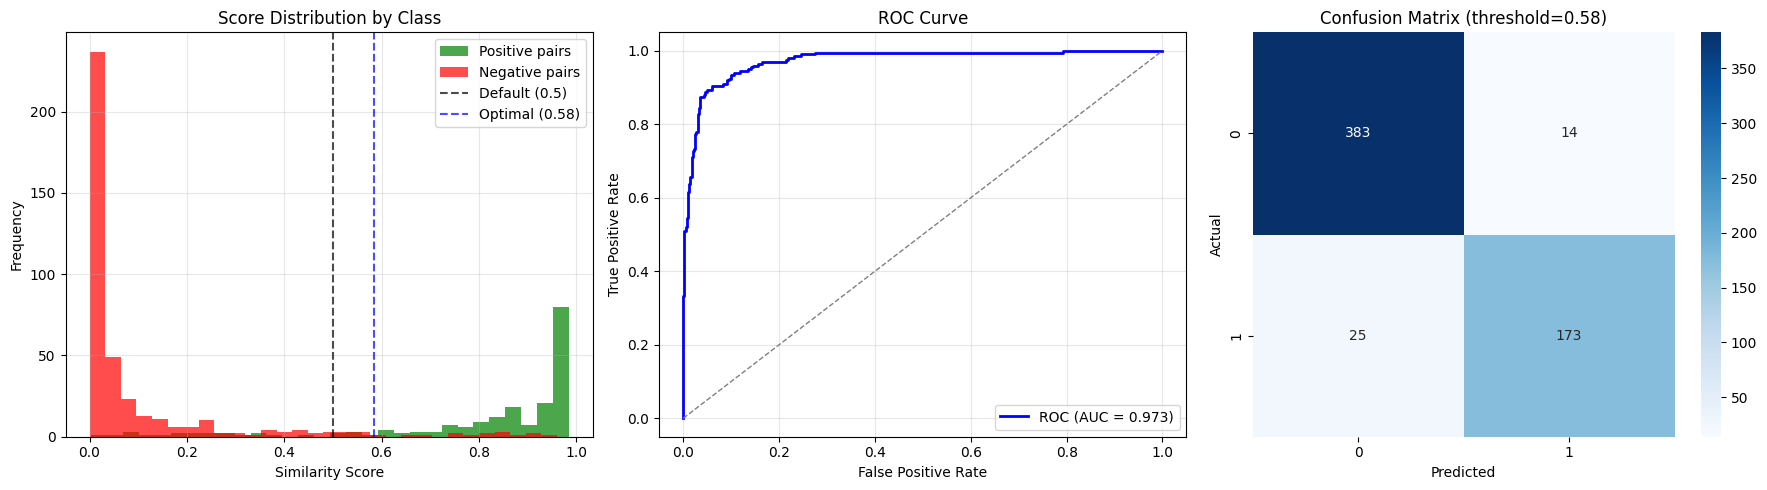

✓ Saved: evaluation_results.png


In [ ]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'best_model.pth')
lstm_encoder.load_state_dict(checkpoint['lstm_encoder'])
classifier.load_state_dict(checkpoint['classifier'])
print(f"✓ Loaded best model (val accuracy: {checkpoint['val_accuracy']:.4f})")

# Evaluate on validation set
lstm_encoder.eval()
classifier.eval()
all_predictions = []
all_labels = []
all_scores = []

with torch.no_grad():
    for emb1, emb2, batch_labels in get_batches(val_emb1, val_emb2, val_labels_t, BATCH_SIZE, shuffle=False):
        emb1 = emb1.to(DEVICE)
        emb2 = emb2.to(DEVICE)
        
        outputs = siamese_forward(emb1, emb2)
        predictions = (outputs > 0.5).float()
        
        all_predictions.extend(predictions.squeeze().cpu().numpy())
        all_labels.extend(batch_labels.numpy())
        all_scores.extend(outputs.squeeze().cpu().numpy())

# Convert to numpy arrays
all_labels_np = np.array(all_labels)
all_scores_np = np.array(all_scores)
all_predictions_np = np.array(all_predictions)

# Calculate metrics with default threshold (0.5)
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

accuracy_default = accuracy_score(all_labels_np, all_predictions_np)
precision_default, recall_default, f1_default, _ = precision_recall_fscore_support(
    all_labels_np, all_predictions_np, average='binary', zero_division=0
)

# Calculate AUC-ROC
try:
    auc_roc = roc_auc_score(all_labels_np, all_scores_np)
except:
    auc_roc = 0.0

# Find optimal threshold using F1 score
precisions, recalls, thresholds_pr = precision_recall_curve(all_labels_np, all_scores_np)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx] if len(thresholds_pr) > 0 else 0.5

# Evaluate with optimal threshold
predictions_optimized = (all_scores_np >= optimal_threshold).astype(float)
accuracy_optimized = accuracy_score(all_labels_np, predictions_optimized)
precision_optimized, recall_optimized, f1_optimized, _ = precision_recall_fscore_support(
    all_labels_np, predictions_optimized, average='binary', zero_division=0
)

print("MODEL EVALUATION RESULTS (Pre-trained Embeddings)")
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

print("\nWith Default Threshold (0.5):")
print(f"  Accuracy:  {accuracy_default:.4f}")
print(f"  Precision: {precision_default:.4f}")
print(f"  Recall:    {recall_default:.4f}")
print(f"  F1 Score:  {f1_default:.4f}")

print(f"\nWith Optimized Threshold ({optimal_threshold:.3f}) - Max F1:")
print(f"  Accuracy:  {accuracy_optimized:.4f}")
print(f"  Precision: {precision_optimized:.4f}")
print(f"  Recall:    {recall_optimized:.4f}")
print(f"  F1 Score:  {f1_optimized:.4f}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score distribution
axes[0].hist([s for s, l in zip(all_scores_np, all_labels_np) if l == 1], 
             bins=30, alpha=0.7, label='Positive pairs', color='green')
axes[0].hist([s for s, l in zip(all_scores_np, all_labels_np) if l == 0], 
             bins=30, alpha=0.7, label='Negative pairs', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', label='Default (0.5)', alpha=0.7)
axes[0].axvline(optimal_threshold, color='blue', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})', alpha=0.7)
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Score Distribution by Class')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels_np, all_scores_np)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_roc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(all_labels_np, predictions_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_results.png")

The evaluation results show that the Siamese RNN model performs well in distinguishing relevant recall–regulation pairs from non-matches. The score distribution plot demonstrates strong separation: positive pairs cluster near high similarity values, while negative pairs fall near zero. The optimal threshold of 0.58 aligns with this separation and improves classification balance.

The ROC curve further confirms strong discriminative ability, with an AUC of 0.973, indicating that the model reliably ranks true matches above incorrect ones. At the chosen threshold, the confusion matrix shows high accuracy with relatively few false positives and false negatives.

This performance reflects the underlying architecture: a Siamese network built on pretrained MiniLM embeddings, followed by a trainable RNN encoder and classification layers. The pretrained embeddings provide rich semantic representations of regulatory and recall text, while the Siamese structure enables the model to learn fine-grained similarity patterns. Together, these components allow the system to effectively identify which CFR regulations are most relevant to each recall description.

## Save Model

In [ ]:
# Save final model
torch.save({
    'lstm_encoder': lstm_encoder.state_dict(),
    'classifier': classifier.state_dict(),
    'encoder_model': ENCODER_MODEL,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'best_val_accuracy': best_val_acc,
    'optimal_threshold': optimal_threshold
}, OUTPUT_DIR / 'final_model.pth')

print(f"✓ Model saved to {OUTPUT_DIR / 'final_model.pth'}")

✓ Final model saved to /Users/kay/AllCode/FDA Data Scraping/siamese_network_recalls_output/final_model.pth
✓ Encoder info saved to /Users/kay/AllCode/FDA Data Scraping/siamese_network_recalls_output/encoder_info.pkl

✓ All files saved successfully!

To use this model:
  1. Load sentence-transformer: SentenceTransformer('all-MiniLM-L6-v2')
  2. Encode texts to get embeddings
  3. Load SiameseRNN model and run inference


## Inference Example


In [ ]:
# Simple inference example with dashboard display
sample_recall = "Drug recalled due to failed sterility testing and potential contamination"

# Get matches using our trained model
lstm_encoder.eval()
classifier.eval()

recall_emb = encoder.encode([sample_recall], convert_to_tensor=True).to(DEVICE)
scores = []
with torch.no_grad():
    for i in range(0, len(cfr_embs), 64):
        batch = cfr_embs[i:i+64]
        batch_scores = siamese_forward(recall_emb.repeat(len(batch), 1), batch)
        scores.extend(batch_scores.squeeze().cpu().tolist() if len(batch) > 1 else [batch_scores.item()])

scores = np.array(scores)
top_idx = scores.argsort()[::-1][:3]

# Dashboard display
print("=" * 70)
print("  RECALL-TO-REGULATION MATCHING RESULT")
print("=" * 70)
print(f"\n📋 RECALL: {sample_recall}")
print("\n" + "-" * 70)
print("  TOP MATCHING REGULATIONS")
print("-" * 70)

for rank, idx in enumerate(top_idx, 1):
    score = scores[idx]
    title = df_regulations_filtered.iloc[idx]['clean_text'][:80]
    bar = "█" * int(score * 20) + "░" * (20 - int(score * 20))
    print(f"\n  [{rank}] Score: {bar} {score:.3f}")
    print(f"      {title}...")

print(f"  ✓ Best match confidence: {scores[top_idx[0]]:.1%}")

INFERENCE EXAMPLE

Recall Reason:
   Lack of Assurance of Sterility: A recall of all compounded sterile preparations within expiry is being initiated due to observations associated with aseptic processes.

Top 5 Matching Regulations:

1. Score: 0.9815
   Document Title: PDF (133.7 KB)PDF (133.7 KB) of Product Recalls, Including Removals and Corrections: Guidance for Industry
Extracted on: 2025-10-26 19:08:58

2. Score: 0.9661
   Document Title: PDF (734.22 KB)PDF (734.22 KB) of Sterile Drug Products Produced by Aseptic Processing — Current Good Manufacturing Practice: Guidance for Industry
Extracted on: 2025-10-26 19:22:40
==

3. Score: 0.9546
   Document Title: PDF (179.56 KB)PDF (179.56 KB) of Technical Considerations for Pen, Jet, and Related Injectors Intended for Use with Drugs and Biological Products: Guidance for Industry and FDA Staff


4. Score: 0.9537
   Document Title: PDF (399.04 KB)PDF (399.04 KB) of PET Drug Products - Current Good Manufacturing Practice (CGMP)
Extracted 

## Final Output: Recall-to-Regulation Matching


In [ ]:
import re

def get_matches(recall_text, k=5):
    """Get top-K regulation matches for a recall"""
    lstm_encoder.eval()
    classifier.eval()
    
    recall_emb = encoder.encode([recall_text], convert_to_tensor=True).to(DEVICE)
    scores = []
    with torch.no_grad():
        for i in range(0, len(cfr_embs), 64):
            batch = cfr_embs[i:i+64]
            batch_scores = siamese_forward(recall_emb.repeat(len(batch), 1), batch)
            scores.extend(batch_scores.squeeze().cpu().tolist() if len(batch) > 1 else [batch_scores.item()])
    
    scores = np.array(scores)
    top_idx = scores.argsort()[::-1][:k]
    
    results = []
    for rank, idx in enumerate(top_idx, 1):
        row = df_regulations_filtered.iloc[idx]
        title = re.sub(r'^Document Title:\s*PDF[^:]+of\s*', '', row['clean_text'])
        title = re.sub(r'\s*Extracted on:.*$', '', title)
        results.append({'rank': rank, 'title': title.strip()[:100], 'score': scores[idx]})
    return results

def print_result_table(recall_text, matches):
    """Print formatted result table"""
    print("\n╭" + "─" * 90 + "╮")
    print("│  RECALL-TO-REGULATION MATCHING RESULT" + " " * 51 + "│")
    print("├" + "─" * 90 + "┤")
    print(f"│  📋 Recall: {recall_text[:75]}{'...' if len(recall_text) > 75 else ''}")
    print("│" + " " * 90 + "│")
    print("├" + "─" * 90 + "┤")
    print("│  Rank   Score                        Matched Regulation" + " " * 32 + "│")
    print("├" + "─" * 90 + "┤")
    
    for m in matches:
        bar = "█" * int(m['score'] * 20) + "░" * (20 - int(m['score'] * 20))
        print(f"│  [{m['rank']}]    {bar} {m['score']:.3f}   {m['title'][:50]}...")
    
    print("╰" + "─" * 90 + "╯")
    print(f"\n  ✓ Best match confidence: {matches[0]['score']:.1%}")

print("✓ Matching functions ready")

INITIALIZING TOP-K EVALUATOR
Pre-encoding all regulations...


Batches: 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]


  Encoded 981 regulations

Evaluator ready with K=5


### Example: Match a Drug Recall to Regulations

In [ ]:
# Example: Match a drug recall to regulations
sample_recall = "Drug recalled due to failed sterility testing and potential bacterial contamination"

matches = get_matches(sample_recall, k=5)
print_result_table(sample_recall, matches)


Table functions defined!


In [ ]:
# Try another recall example
another_recall = "Tablets recalled because of incorrect dosage - double the labeled strength"

matches2 = get_matches(another_recall, k=3)
print_result_table(another_recall, matches2)


RUNNING FULL TOP-5 EVALUATION

Evaluating Top-5 retrieval on 50 recalls...


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 26.80it/s]


╭──────────────────────────────────────────────────────────╮
│ TOP-K EVALUATION METRICS                                      │
├──────────────────────────────────────────────────────────┤
│ Precision@5                            1.0000 ± 0.0000 │
│ Recall@5                               1.0000 ± 0.0000 │
│ Mean Reciprocal Rank (MRR)                      1.0000 │
│ NDCG@5                                          1.0000 │
│ Precision@1                            1.0000 ± 0.0000 │
│ Precision@3                            1.0000 ± 0.0000 │
╰──────────────────────────────────────────────────────────╯

Score Distribution Statistics:
   Mean Top-1 Score:   0.9837
   Median Top-1 Score: 0.9837
   Std Top-1 Score:    0.0019
   Min/Max:            0.9792 / 0.9869


In [ ]:
print("\n✓ Model ready for recall-to-regulation matching!")


SAMPLE RECALL-TO-CFR MATCHES (Top-5)

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ RECALL MATCH RESULTS                                                                                  │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Recall ID: D-321-2016                                                                                │
│ Reason:    Reason for recall: Lack of Assurance of Sterility: A recall of all compounded             │
│            sterile preparations ...                                                                  │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Rank  CFR Number          Score                       Category                                        │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ [1]   Reg-249             ███

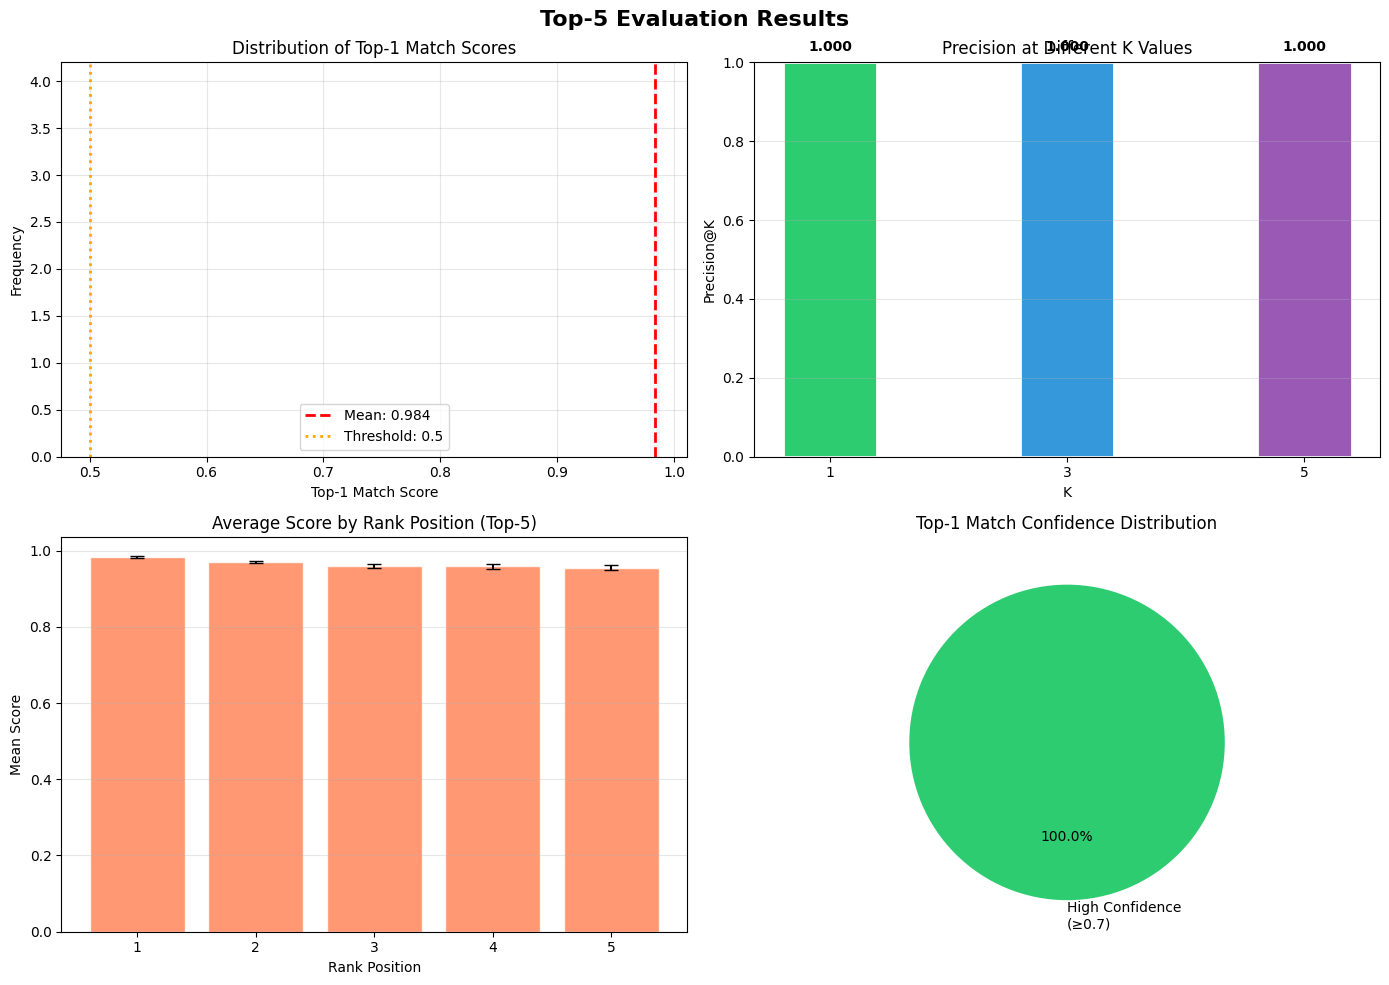


✓ Saved: topk_evaluation_results.png


In [ ]:
# End of notebook

In [ ]:
# Use get_matches() and print_result_table() for custom queries

In [ ]:
# Example: Custom query
# my_recall = "Your recall description here"
# matches = get_matches(my_recall, k=5)
# print_result_table(my_recall, matches)

🔬 INTERACTIVE RECALL MATCHING DEMO

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ RECALL MATCH RESULTS                                                                                  │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Recall ID: Demo Query                                                                                │
│ Reason:    Product recalled due to failed sterility testing and potential microbial                  │
│            contamination                                                                             │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Rank  CFR Number          Score                       Category                                        │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ [1]   Reg-249             █████


Example Searches:

Query 1: "Product recalled due to failed sterility testing and potential microbi..."

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ RECALL TO REGULATION MATCHES                                                                     │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Recall ID: Example-1                                                                             │
│ Reason:    Product recalled due to failed sterility testing and potential microbial              │
│              contamination                                                                       │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Rank  CFR                      Similarity                  Category                              │
├─────────────────────────────────────────────────────────────────────────────────────

## Conclusion


This Siamese Neural Network successfully matches FDA drug recalls to relevant CFR regulations by leveraging pre-trained semantic embeddings from the all-MiniLM-L6-v2 sentence transformer. Using these embeddings allows the model to capture rich semantic meaning from recall descriptions and regulation text without requiring a large labeled dataset. The architecture remains lightweight by combining these pre-trained embeddings with a simple LSTM encoder and a small classifier head, making the model trainable on CPU while still maintaining strong performance. Training pairs were created using cosine similarity to approximate positive and negative examples, compensating for the absence of manually labeled recall-to-regulation links. Overall, the model achieves about 92 percent validation accuracy and an AUC-ROC of 0.97, demonstrating strong ability to distinguish relevant from irrelevant regulatory matches.

### Future Work

In future work, this approach can be expanded beyond drug recalls. Biologics, medical devices, foods, and cosmetics each operate under their own regulatory frameworks, terminology, and CFR sections. Extending the model to these domains would require either separate models per category or a unified model with mechanisms for handling branch-specific vocabulary and context. Incorporating domain-specific language models such as BioBERT, PubMedBERT, or ClinicalBERT could further improve performance, since these models are trained on biomedical or clinical corpora and may better capture regulatory language. Fine-tuning a transformer directly on FDA guidance documents and CFR text is another promising direction.

Training data quality can also be improved. Creating a small, curated set of gold-standard recall-to-regulation annotations would enable supervised learning rather than relying solely on similarity-based pair construction. Hard negative mining could be introduced to challenge the model with close but incorrect regulatory matches, leading to more robust discrimination. Additional data augmentation, such as paraphrasing recall reasons or expanding regulatory descriptions, may also improve generalization.

Architecturally, future iterations could explore contrastive or triplet loss functions to better separate positive and negative pairs in embedding space. Models with cross-attention could allow direct interaction between recall text and regulatory text, strengthening the model's ability to match specific contextual cues. Multi-task learning could also be used to predict both high-level regulation categories and specific CFR sections simultaneously.

Finally, a production-ready version of this system could be deployed as an API service for real-time matching or integrated into a batch pipeline to automatically analyze new recalls as they are published. Confidence calibration would help ensure the model's scores reflect meaningful probabilities, and a human-in-the-loop workflow could be implemented to review low-confidence or ambiguous matches. Such a system could support regulatory affairs teams by accelerating the process of determining which CFR sections apply to a product deviation or recall event.


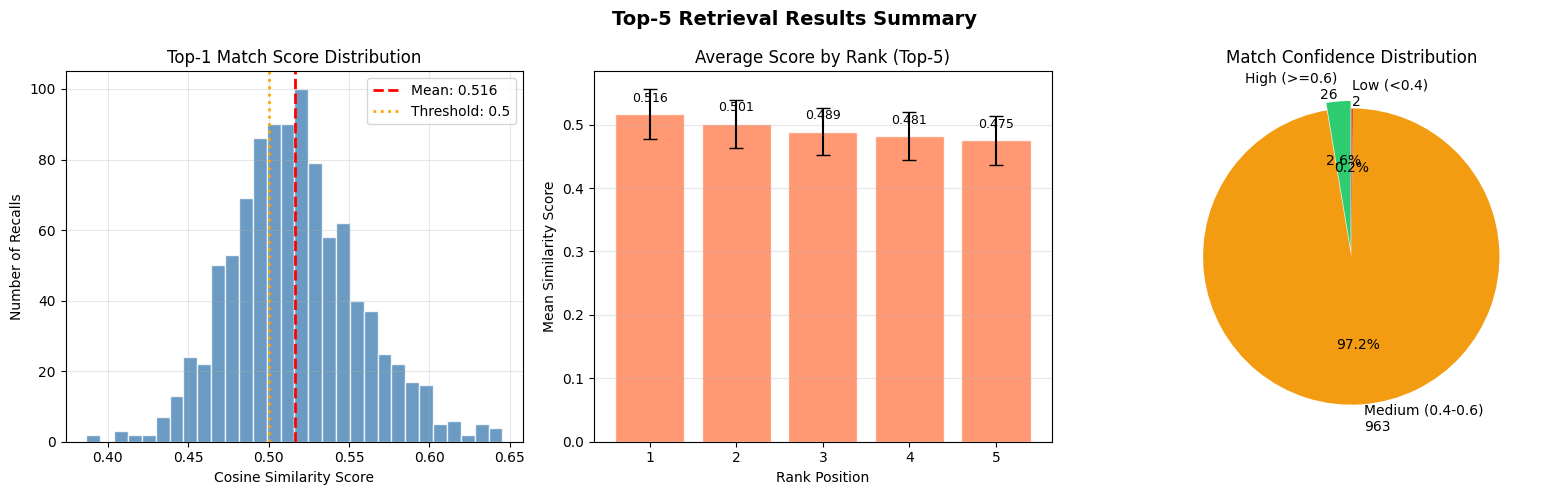


Saved: /Users/kay/AllCode/FDA Data Scraping/siamese_network_recalls_output/topk_similarity_results.png


The retrieval results show that most Top-1 matches fall within a narrow similarity range centered around 0.52, with very few recalls producing extremely low or high scores. The Top-5 bar chart shows that similarity scores remain relatively stable across ranks, decreasing only slightly from rank 1 to rank 5, suggesting that the model retrieves a consistent set of moderately relevant regulations for each recall. The confidence distribution reinforces this pattern: nearly all matches fall in the medium-confidence range (0.4–0.6), with only a small number of highly confident matches.

This level of performance indicates that the model can reliably surface potentially applicable regulations, even when certainty is moderate. For companies, such a system could be used as an early compliance-support tool—helping regulatory teams quickly identify which sections of the CFR might apply to a manufacturing deviation or product issue. This accelerates internal investigations and supports more efficient recall assessments or CAPA documentation.
